# Project 3: Gradient Domain Editing

[https://github.com/meterglost/HCMUT-CO3057-DigitalImageProcessing-ComputerVision](https://github.com/meterglost/HCMUT-CO3057-DigitalImageProcessing-ComputerVision/tree/main/project/project3.ipynb)

## Setup

In [1]:
%pip install --quiet opencv-python-headless numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2 as cv
import numpy as np
from IPython.display import display, Image

## Sample image

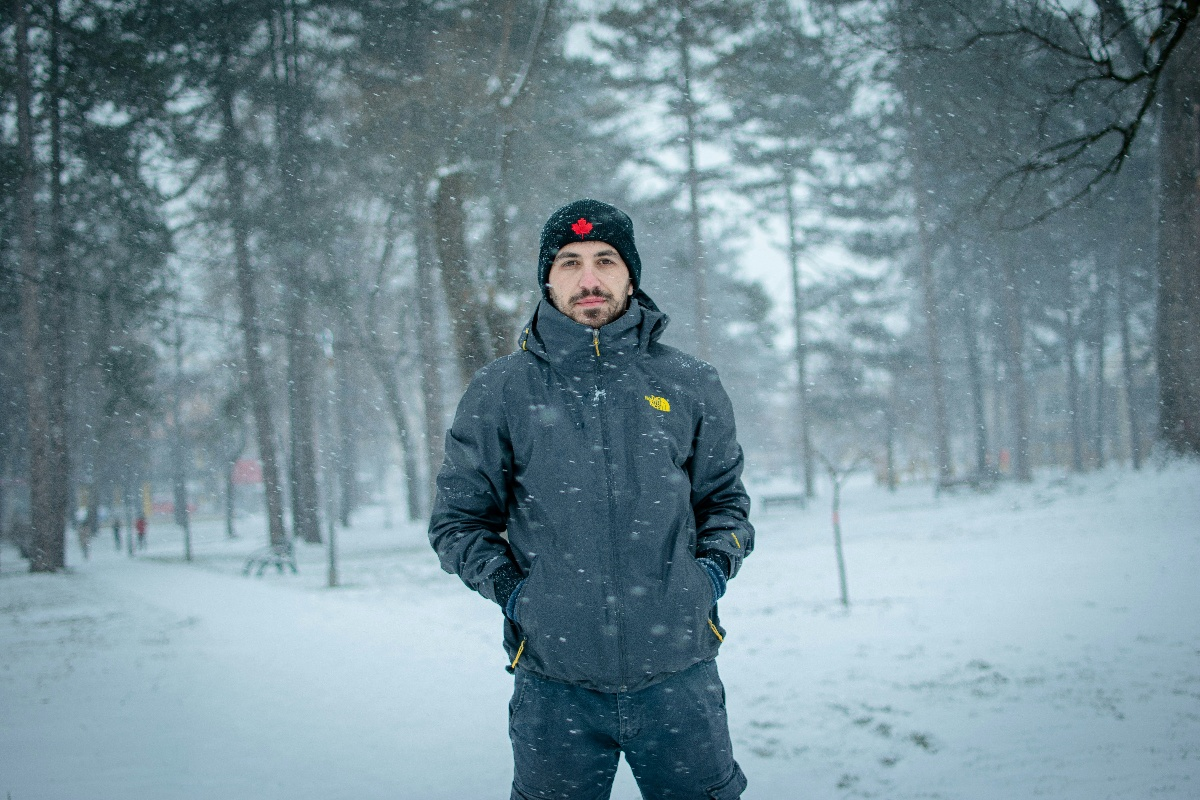

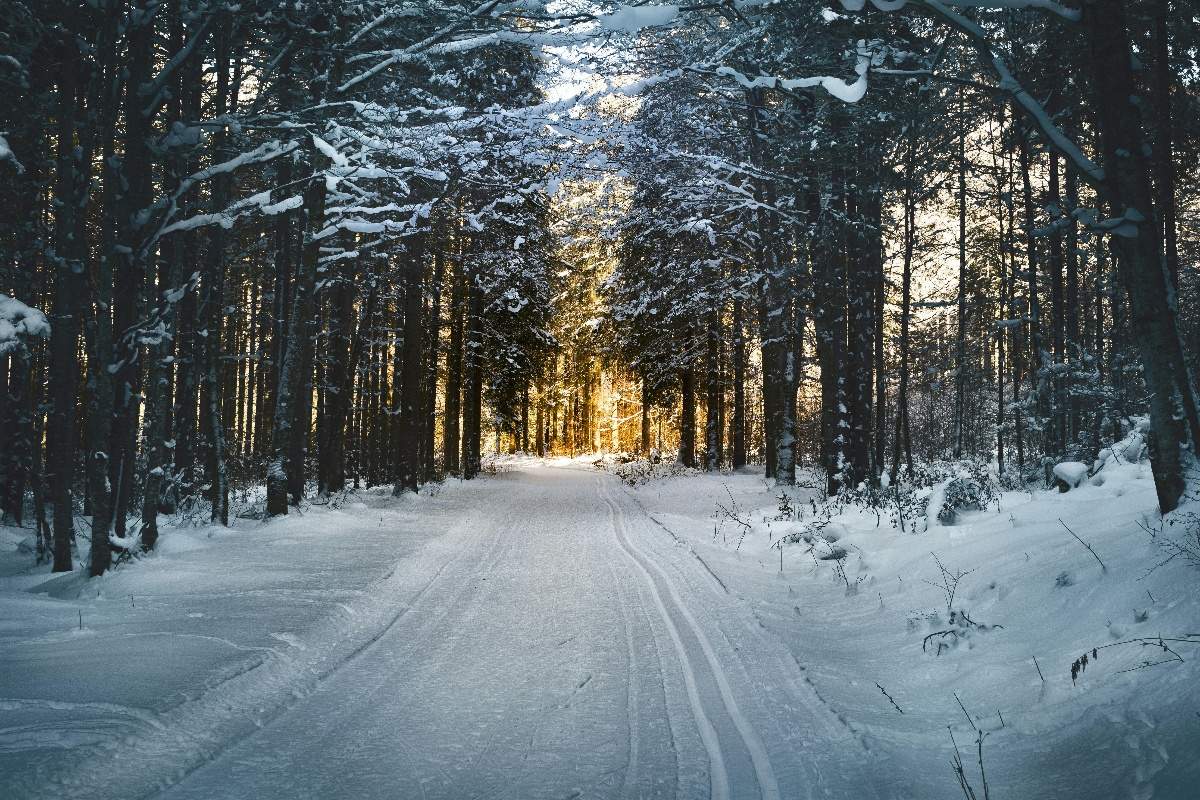

In [32]:
ob = cv.imread("../sample/object.jpg")
ob_scaledown = cv.resize(ob, (ob.shape[1]//5, ob.shape[0]//5))

bg = cv.imread("../sample/background.jpg")
bg_scaledown = cv.resize(bg, (ob_scaledown.shape[1], ob_scaledown.shape[0]))

display(
    Image(cv.imencode(".jpg", ob_scaledown)[1].tobytes()),
    Image(cv.imencode(".jpg", bg_scaledown)[1].tobytes()),
)

## Mask object

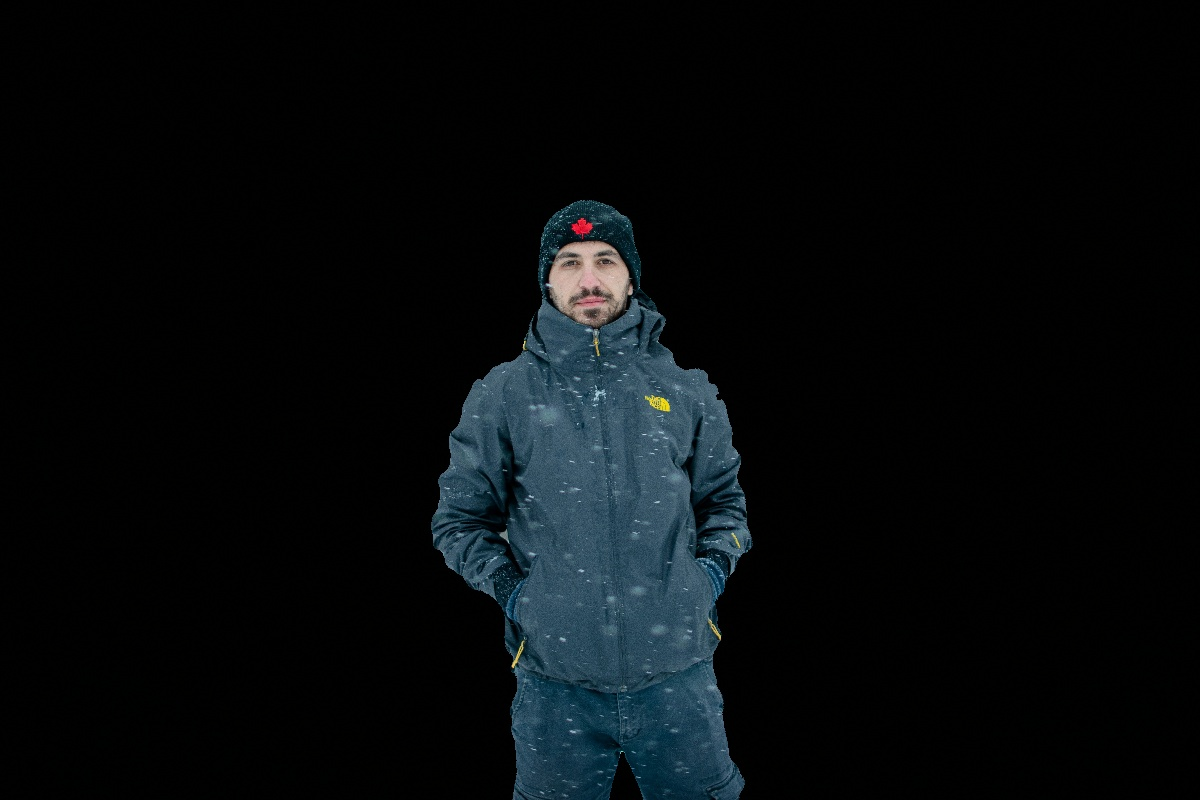

In [26]:
channel = cv.split(ob_scaledown)
channel_mask = [[[]] for _ in range(3)]

for i in range(3):
    equalize = cv.equalizeHist(channel[i])

    blur = cv.bilateralFilter(equalize, 15, 175, 175)

    _, thresh = cv.threshold(blur, 65, 255, cv.THRESH_BINARY_INV)
    # display(Image(cv.imencode(".jpg", thresh)[1].tobytes()))

    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    ctarea = [cv.contourArea(c) for c in contours]

    mask = np.ones((ob_scaledown.shape), np.uint8)
    mask = cv.drawContours(mask, contours, ctarea.index(sorted(ctarea, reverse=True)[0]), (255, 255, 255), cv.FILLED)
    # display(Image(cv.imencode(".jpg", mask)[1].tobytes()))

    channel_mask[i] = mask

mask = channel_mask[0] | channel_mask[1] | channel_mask[2]

# mask = cv.resize(mask, (obj.shape[1], obj.shape[0]))
# mask = cv.erode(mask, None, iterations=15)
# mask = cv.blur(mask, (15, 15))

masked_ob = ob_scaledown & mask
display(Image(cv.imencode(".jpg", masked_ob)[1].tobytes()))

## Poison blending

Poisson blending is a technique that allows us to seamlessly combine two images. It leverages the Poisson equation to enforce smoothness and continuity constraints between the source and target images. This powerful method is used widely in image processing for the creation of high-quality images without visible distortions or artifacts.

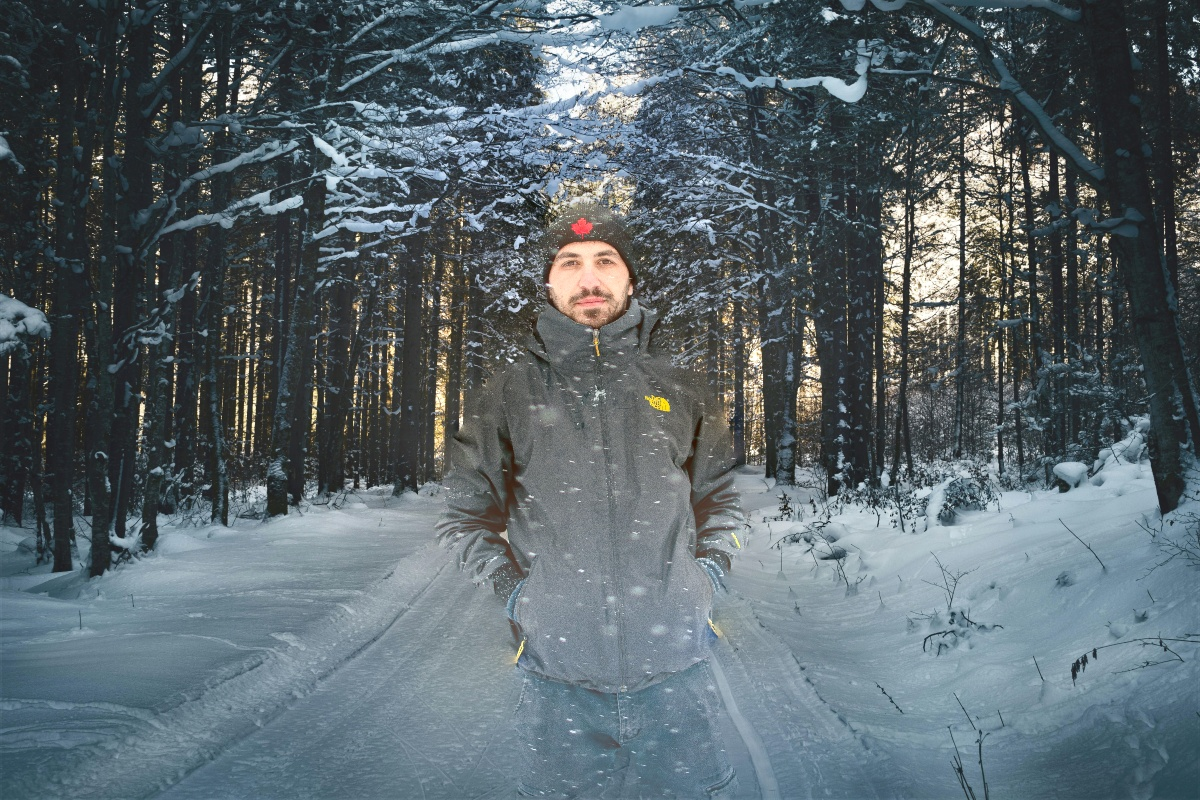

In [27]:
img = cv.seamlessClone(ob_scaledown, bg_scaledown, mask, (bg_scaledown.shape[1]//2, bg_scaledown.shape[0]//2), cv.NORMAL_CLONE)

display(Image(cv.imencode(".jpg", img)[1].tobytes()))

## Laplacian Pyramid Blending

Laplacian pyramid blending uses a multi-scale representation - a Laplacian pyramid - for blending images. The pyramid levels are combined using a mask that defines each level's contribution to the final blended image. The blending process starts at the top level and the outcome is added to the corresponding level of the blended image pyramid.

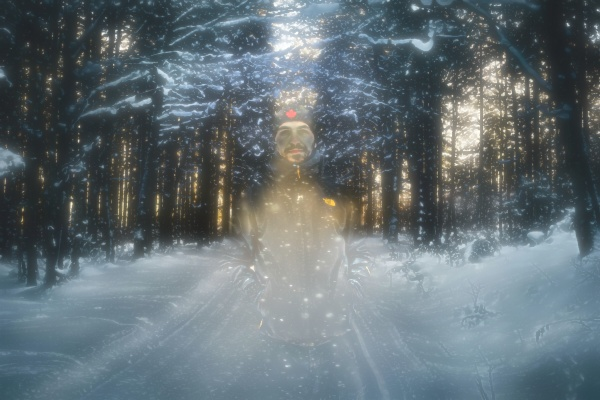

In [37]:
# generate Gaussian pyramid for object
gpA = [ob_scaledown.copy()]
for i in range(4):
    gpA.append(cv.pyrDown(gpA[i]))

# generate Gaussian pyramid for background
gpB = [bg_scaledown.copy()]
for i in range(4):
    gpB.append(cv.pyrDown(gpB[i]))

gpA.reverse()
gpB.reverse()

# generate Laplacian Pyramid for object
lpA = [gpA[0]]
for i in range(1, 4):
    lpA.append(cv.subtract(gpA[i], cv.pyrUp(gpA[i-1])))

# generate Laplacian Pyramid for background
lpB = [gpB[0]]
for i in range(1, 4):
    lpB.append(cv.subtract(gpB[i], cv.pyrUp(gpB[i-1])))

# Blending
LS = []
for la, lb in zip(lpA, lpB):
    lm = cv.resize(mask, (la.shape[1], la.shape[0]))
    LS.append(cv.seamlessClone(la, lb, lm, (lb.shape[1]//2, lb.shape[0]//2), cv.NORMAL_CLONE))

# Reconstruct
img = LS[0]
for i in range(1, 4):
    img = cv.add(cv.pyrUp(img), LS[i])

display(Image(cv.imencode(".jpg", img)[1].tobytes()))